In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z < 12)
    raw = int(cp.count_nonzero(mask).get())
    return raw

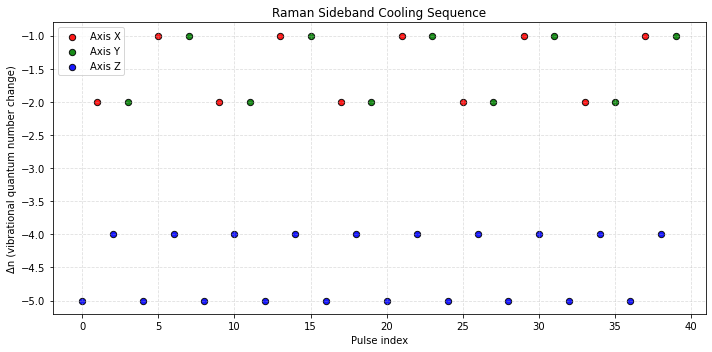

In [2]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[1], (5, 1)),  # repeat 5 times
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

In [9]:
np.save("XYZ1_original.npy", cp.asarray(seq_gpu))

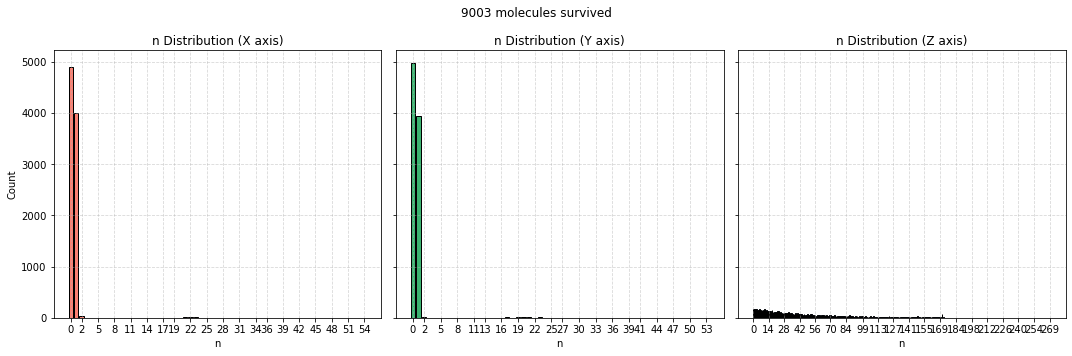

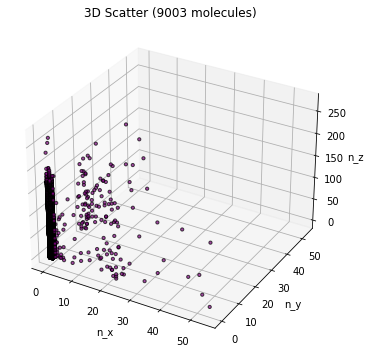

Raman pulses: 100%|██████████| 40/40 [00:06<00:00,  5.73it/s]


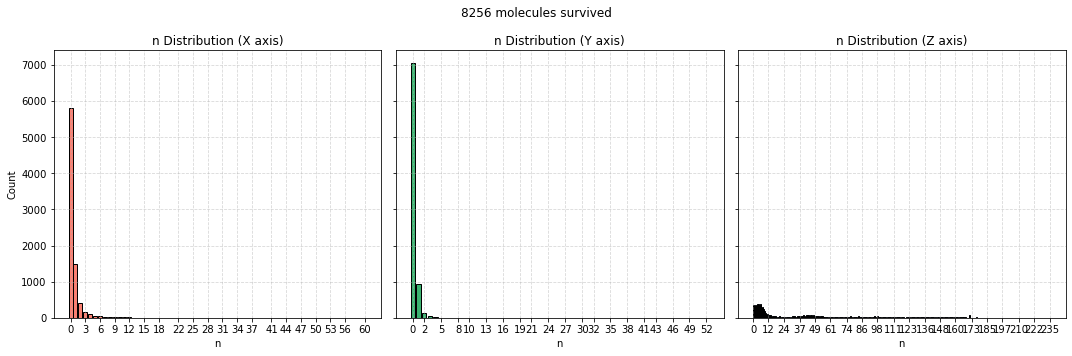

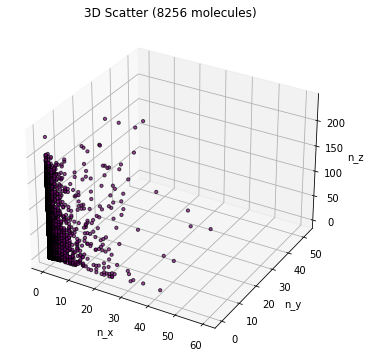

survival_rate_mean 0.8256
mot_mean [ 0.78621609  0.32521802 46.03209787]
mot_sem [0.00093787 0.00072427 0.01761191]


In [10]:
mol_0 = cp.asarray(np.load("mol_post_XY.npy"))
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [11]:
score_sequence(mol_0)

2461

#### Optimized

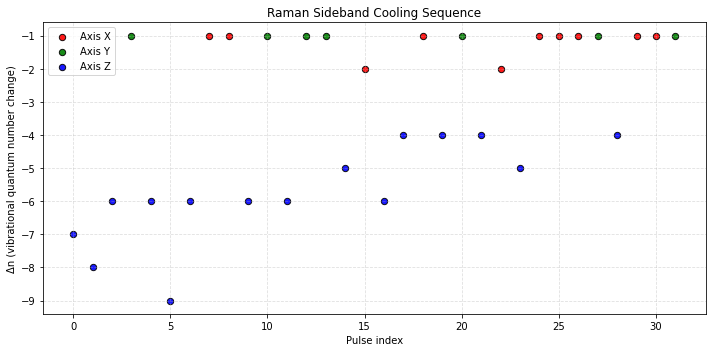

In [3]:
seq_op = cp.array(np.load("ga_runs/XYZ1_20251029_213358/final_top5/top1_sequence.npy"))
cr.visualize_sequence(seq_op)

Raman pulses: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


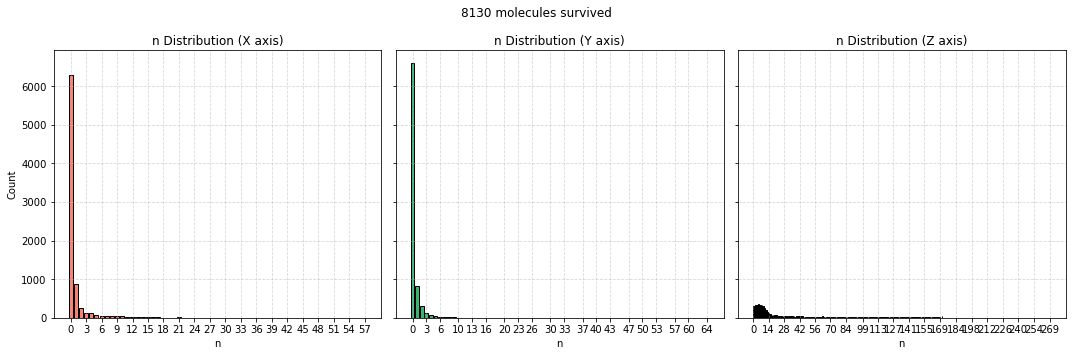

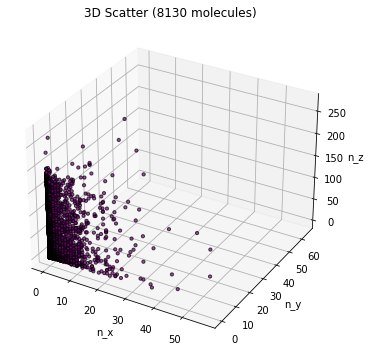

survival_rate_mean 0.813
mot_mean [ 0.91340713  0.55694957 39.90344403]
mot_sem [0.00114981 0.00092292 0.01688398]


In [4]:
mol_1 = cp.asarray(np.load("mol_post_XY.npy"))
cr.raman_cool_with_pumping(mol_1, seq_op, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [5]:
score_sequence(mol_1)

2776

In [6]:
cr.save_molecules(mol_1, "post_XYZ1.npy")

[✓] Molecules saved to: C:\Users\LyuQi\Documents\optimize_sequence\XYZ1\post_XYZ1.npy  (shape=(10000, 6))
